In [1]:
# !pip install seaborn

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
import ipaddress


import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
from sklearn.metrics import confusion_matrix, classification_report

In [26]:
df = pd.read_csv("NUSW-NB15_GT.csv")
df = df.drop(columns=[".","Attack Reference"])
print(len(df))
df.head()

174347


,Start time,Last time,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name
0,1421927414,1421927416,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...
1,1421927415,1421927415,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...
2,1421927416,1421927416,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...
3,1421927417,1421927417,Exploits,Miscellaneous Batch,tcp,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...
4,1421927418,1421927418,Exploits,Cisco IOS,tcp,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...


In [27]:
df["Attack category"] = df["Attack category"].str.lstrip().str.rstrip()
df["Attack category"].value_counts()

Exploits          68217
Fuzzers           33638
DoS               24582
Reconnaissance    20136
Generic           19860
Backdoor           4097
Analysis           1881
Shellcode          1511
Backdoors           256
Worms               169
Name: Attack category, dtype: int64

In [28]:
ordered_attack_cats = df["Attack category"].value_counts().reset_index()["index"].values.tolist()
ordered_attack_cats

['Exploits',
 'Fuzzers',
 'DoS',
 'Reconnaissance',
 'Generic',
 'Backdoor',
 'Analysis',
 'Shellcode',
 'Backdoors',
 'Worms']

In [29]:
def convert_col_tfidf(df, col):
    vec = TfidfVectorizer()
    x = vec.fit_transform(df[col])
    df1 = pd.DataFrame(x.toarray(), columns=vec.get_feature_names_out())
    res = pd.concat([new_df, df1], axis=1)
    return res

def ip_to_int(ip):
    return int(ipaddress.IPv4Address(ip))

def convert_ip_num(df, cols):
    for idx, col in enumerate(cols):
        df[col + " num"] = df[col].apply(ip_to_int)
    return df

def convert_cate_num(df, cols):
    for idx, col in enumerate(cols):
        df[col].replace(df[col].unique(), range(len(df[col].unique())), inplace=True)
    return df

def convert_to_numeric(df, cols):
    for col in cols:
        df[col] = pd.to_numeric(df[col])
    return df

In [62]:
def run_kmeans(n_clusters=10, x_train=None, y_train=None, cat_idx_map=None, idx_cat_map=None):
    kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 50, n_init = 10, random_state = 0)
    y_kmeans = kmeans.fit_predict(x_train)
    cf_matrix = confusion_matrix(y_kmeans, y_train, labels=list(cat_idx_map.values()))
    print(cf_matrix)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                fmt='.1%', cmap='Blues')

    plt.figure()
    for idx in range(len(cf_matrix)):
        plt.scatter(x_train.iloc[y_kmeans == idx, 0], x_train.iloc[y_kmeans == idx, 0], 
                    label=idx_cat_map[idx], alpha = 0.5, s = 10)

    #Plotting the centroids of the clusters
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], label = 'Centroids',
               alpha = 0.5, s = 100, c='red')

    plt.legend()
    plt.show()

In [51]:
def apply_ml_model(ml_model_list):
    for ml in ml_model_list:
        # Training the model
        ml.fit(x_train, y_train)
        # Predicting the class label for the Test data  
        pred = ml.predict(x_test)  
        # Evaluating the predicted class labels using accuracy score
        print("Accuracy Score: ", accuracy_score(y_test, pred), sep="\n")  
        # Generating a classification report for the predicted class labels
        print("Classification Report: ", classification_report(y_test, pred), sep="\n") 
        # Generating the confusion matrix to know the true-positives, true-negatives, false-positives and false-negatives
        cm = confusion_matrix(y_test, pred)
        print("Confusion Matrix: \n", cm)
        f, ax = plt.subplots(figsize=(5, 5))
        # Heatmap for the confusin matrix using seaborn
        sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
        plt.xlabel("y_pred")
        plt.ylabel("y_true")
        plt.show()

## Supervised Approach - Classification using Logistic Regression and Random Forest



 ******************** 

 Running Expts on ['Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Generic'] 

 ********************
len of fil_df 166433
unique cats ['Reconnaissance' 'Exploits' 'DoS' 'Generic' 'Fuzzers']
len of fil_df after dropping na 118235
unique cats ['Reconnaissance' 'Exploits' 'DoS' 'Generic' 'Fuzzers']
len of new_df 94588
unique cats new_df ['Exploits' 'Fuzzers' 'DoS' 'Generic' 'Reconnaissance']
unique cats y_train [2 0 3 4 1]


 ==================== Logistic Regression Classifier ==================== 


Accuracy Score: 
0.5742678930119463
Classification Report: 
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      5432
           1       0.00      0.00      0.00       317
           2       0.00      0.00      0.00      1992
           3       0.00      0.00      0.00      1550
           4       0.00      0.00      0.00       168

    accuracy                           0.57      9459
   macro avg       0.11      0

/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


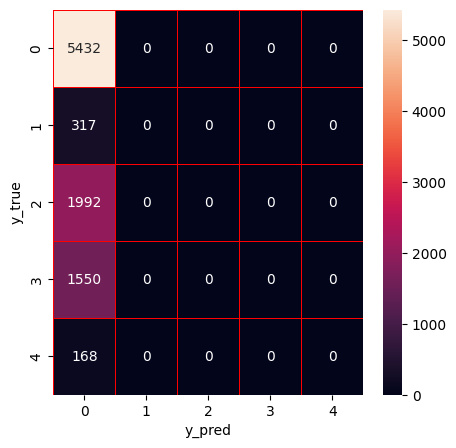

Accuracy Score: 
0.5742678930119463
Classification Report: 
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      5432
           1       0.00      0.00      0.00       317
           2       0.00      0.00      0.00      1992
           3       0.00      0.00      0.00      1550
           4       0.00      0.00      0.00       168

    accuracy                           0.57      9459
   macro avg       0.11      0.20      0.15      9459
weighted avg       0.33      0.57      0.42      9459

Confusion Matrix: 
 [[5432    0    0    0    0]
 [ 317    0    0    0    0]
 [1992    0    0    0    0]
 [1550    0    0    0    0]
 [ 168    0    0    0    0]]


/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


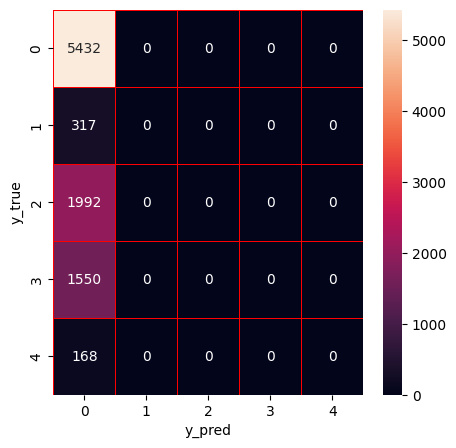



 ==================== Random Forest Classifier ==================== 


Accuracy Score: 
0.7538851887091659
Classification Report: 
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      5432
           1       0.87      0.66      0.75       317
           2       0.52      0.37      0.43      1992
           3       0.97      0.89      0.93      1550
           4       0.73      0.58      0.65       168

    accuracy                           0.75      9459
   macro avg       0.77      0.67      0.71      9459
weighted avg       0.74      0.75      0.74      9459

Confusion Matrix: 
 [[4694   15  678   28   17]
 [  89  208   12    1    7]
 [1214    8  744   13   13]
 [ 162    0    1 1387    0]
 [  53    9    8    0   98]]


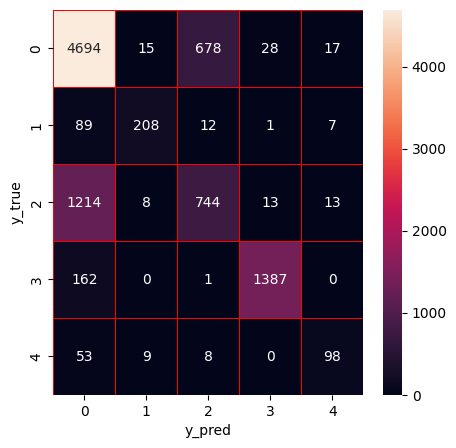

Accuracy Score: 
0.7551538217570568
Classification Report: 
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      5432
           1       0.86      0.66      0.75       317
           2       0.52      0.37      0.43      1992
           3       0.97      0.90      0.93      1550
           4       0.74      0.60      0.66       168

    accuracy                           0.76      9459
   macro avg       0.77      0.68      0.72      9459
weighted avg       0.74      0.76      0.74      9459

Confusion Matrix: 
 [[4704   16  668   29   15]
 [  86  209   13    1    8]
 [1220    9  737   13   13]
 [ 158    0    0 1392    0]
 [  49    9    9    0  101]]


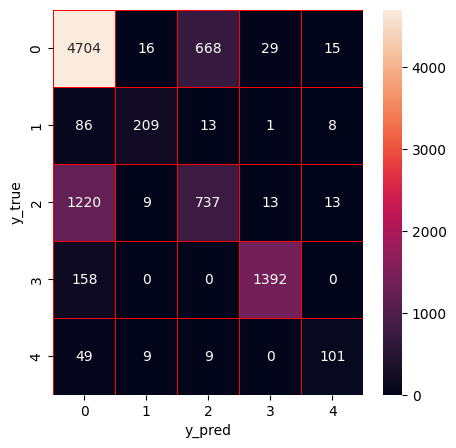



 ==================== SVM Classifier ==================== 




/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy Score: 
0.5742678930119463
Classification Report: 
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      5432
           1       0.00      0.00      0.00       317
           2       0.00      0.00      0.00      1992
           3       0.00      0.00      0.00      1550
           4       0.00      0.00      0.00       168

    accuracy                           0.57      9459
   macro avg       0.11      0.20      0.15      9459
weighted avg       0.33      0.57      0.42      9459

Confusion Matrix: 
 [[5432    0    0    0    0]
 [ 317    0    0    0    0]
 [1992    0    0    0    0]
 [1550    0    0    0    0]
 [ 168    0    0    0    0]]


/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


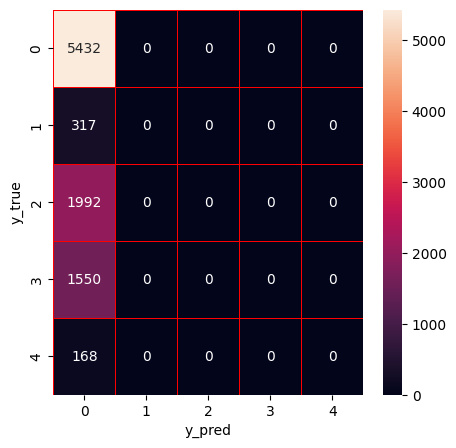

/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy Score: 
0.2004440215667618
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      5432
           1       0.00      0.00      0.00       317
           2       0.26      0.89      0.40      1992
           3       0.00      0.00      0.00      1550
           4       0.04      0.66      0.08       168

    accuracy                           0.20      9459
   macro avg       0.26      0.31      0.10      9459
weighted avg       0.63      0.20      0.09      9459

Confusion Matrix: 
 [[   9    0 4039    0 1384]
 [   0    0  138    0  179]
 [   0    0 1776    0  216]
 [   0    0  853    0  697]
 [   0    0   57    0  111]]


/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


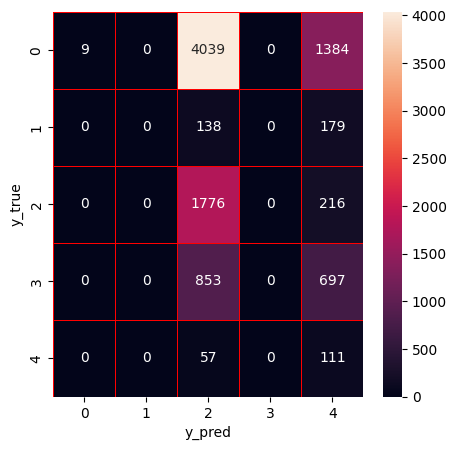



 ******************** 

 Running Expts on ['Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Generic', 'Backdoor'] 

 ********************
len of fil_df 170530
unique cats ['Reconnaissance' 'Exploits' 'DoS' 'Generic' 'Fuzzers' 'Backdoor']
len of fil_df after dropping na 118235
unique cats ['Reconnaissance' 'Exploits' 'DoS' 'Generic' 'Fuzzers']
len of new_df 94588
unique cats new_df ['DoS' 'Exploits' 'Generic' 'Reconnaissance' 'Fuzzers']
unique cats y_train [0 1 4 2 3]


 ==================== Logistic Regression Classifier ==================== 


Accuracy Score: 
0.5858970292842796
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1890
           1       0.59      1.00      0.74      5542
           2       0.00      0.00      0.00      1544
           3       0.00      0.00      0.00       171
           4       0.00      0.00      0.00       312

    accuracy                           0.59      9459
   macr

/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


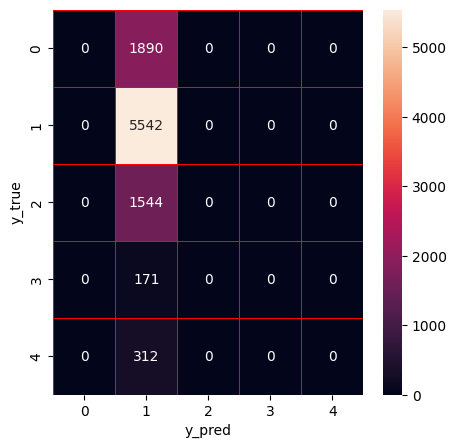

Accuracy Score: 
0.5858970292842796
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1890
           1       0.59      1.00      0.74      5542
           2       0.00      0.00      0.00      1544
           3       0.00      0.00      0.00       171
           4       0.00      0.00      0.00       312

    accuracy                           0.59      9459
   macro avg       0.12      0.20      0.15      9459
weighted avg       0.34      0.59      0.43      9459

Confusion Matrix: 
 [[   0 1890    0    0    0]
 [   0 5542    0    0    0]
 [   0 1544    0    0    0]
 [   0  171    0    0    0]
 [   0  312    0    0    0]]


/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


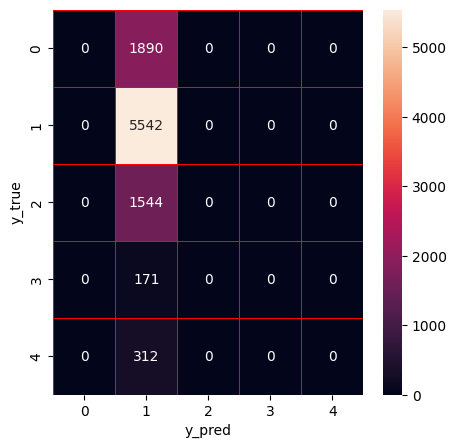



 ==================== Random Forest Classifier ==================== 


Accuracy Score: 
0.772491806744899
Classification Report: 
              precision    recall  f1-score   support

           0       0.55      0.43      0.49      1890
           1       0.78      0.87      0.82      5542
           2       0.97      0.91      0.94      1544
           3       0.74      0.49      0.59       171
           4       0.77      0.52      0.62       312

    accuracy                           0.77      9459
   macro avg       0.76      0.65      0.69      9459
weighted avg       0.76      0.77      0.76      9459

Confusion Matrix: 
 [[ 822 1050    4    4   10]
 [ 635 4830   37   13   27]
 [   9  121 1408    2    4]
 [   8   71    1   84    7]
 [   9  121    9   10  163]]


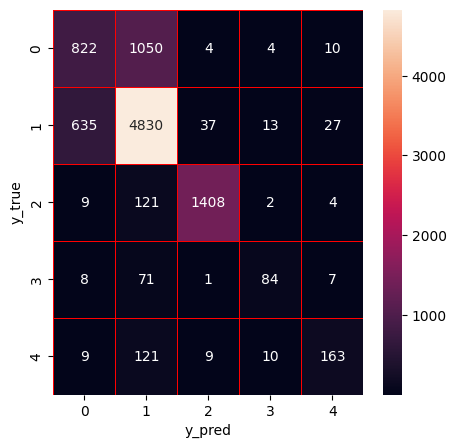

Accuracy Score: 
0.7731261232688444
Classification Report: 
              precision    recall  f1-score   support

           0       0.56      0.43      0.48      1890
           1       0.78      0.88      0.82      5542
           2       0.96      0.91      0.94      1544
           3       0.73      0.50      0.59       171
           4       0.78      0.52      0.63       312

    accuracy                           0.77      9459
   macro avg       0.76      0.65      0.69      9459
weighted avg       0.76      0.77      0.76      9459

Confusion Matrix: 
 [[ 808 1065    5    3    9]
 [ 614 4853   36   13   26]
 [   8  126 1404    2    4]
 [   8   69    3   85    6]
 [  11  116    9   13  163]]


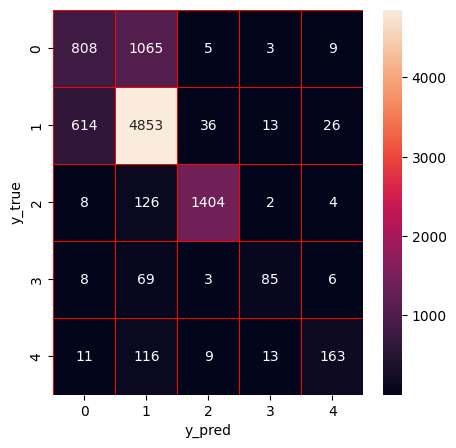



 ==================== SVM Classifier ==================== 




/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy Score: 
0.19980970504281637
Classification Report: 
              precision    recall  f1-score   support

           0       0.20      1.00      0.33      1890
           1       0.00      0.00      0.00      5542
           2       0.00      0.00      0.00      1544
           3       0.00      0.00      0.00       171
           4       0.00      0.00      0.00       312

    accuracy                           0.20      9459
   macro avg       0.04      0.20      0.07      9459
weighted avg       0.04      0.20      0.07      9459

Confusion Matrix: 
 [[1890    0    0    0    0]
 [5542    0    0    0    0]
 [1544    0    0    0    0]
 [ 171    0    0    0    0]
 [ 312    0    0    0    0]]


/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


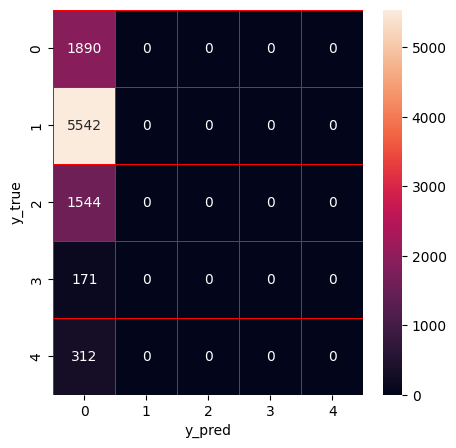

/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy Score: 
0.19663812242308912
Classification Report: 
              precision    recall  f1-score   support

           0       0.25      0.91      0.39      1890
           1       0.95      0.01      0.01      5542
           2       0.00      0.00      0.00      1544
           3       0.04      0.65      0.08       171
           4       0.00      0.00      0.00       312

    accuracy                           0.20      9459
   macro avg       0.25      0.31      0.10      9459
weighted avg       0.61      0.20      0.09      9459

Confusion Matrix: 
 [[1712    1    0  177    0]
 [4047   36    0 1459    0]
 [ 841    1    0  702    0]
 [  59    0    0  112    0]
 [ 146    0    0  166    0]]


/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


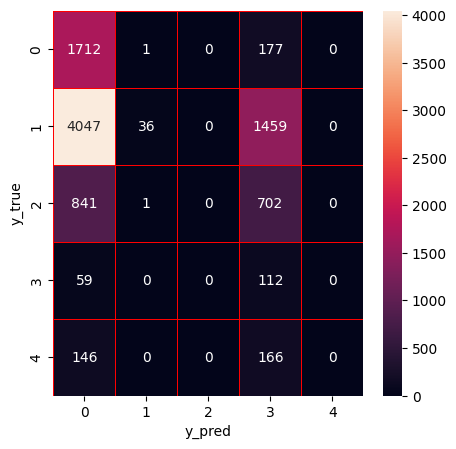



 ******************** 

 Running Expts on ['Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Generic', 'Backdoor', 'Analysis'] 

 ********************
len of fil_df 172411
unique cats ['Reconnaissance' 'Exploits' 'DoS' 'Generic' 'Fuzzers' 'Analysis'
 'Backdoor']
len of fil_df after dropping na 118499
unique cats ['Reconnaissance' 'Exploits' 'DoS' 'Generic' 'Fuzzers' 'Analysis']
len of new_df 94799
unique cats new_df ['DoS' 'Exploits' 'Generic' 'Fuzzers' 'Reconnaissance' 'Analysis']
unique cats y_train [1 2 4 0 3 5]


 ==================== Logistic Regression Classifier ==================== 


Accuracy Score: 
0.5703586497890295
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2008
           1       0.57      1.00      0.73      5407
           2       0.00      0.00      0.00      1566
           3       0.00      0.00      0.00       327
           4       0.00      0.00      0.00       148
           5  

/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


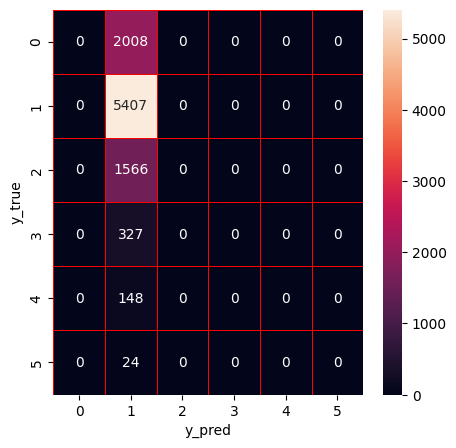

Accuracy Score: 
0.5703586497890295
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2008
           1       0.57      1.00      0.73      5407
           2       0.00      0.00      0.00      1566
           3       0.00      0.00      0.00       327
           4       0.00      0.00      0.00       148
           5       0.00      0.00      0.00        24

    accuracy                           0.57      9480
   macro avg       0.10      0.17      0.12      9480
weighted avg       0.33      0.57      0.41      9480

Confusion Matrix: 
 [[   0 2008    0    0    0    0]
 [   0 5407    0    0    0    0]
 [   0 1566    0    0    0    0]
 [   0  327    0    0    0    0]
 [   0  148    0    0    0    0]
 [   0   24    0    0    0    0]]


/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


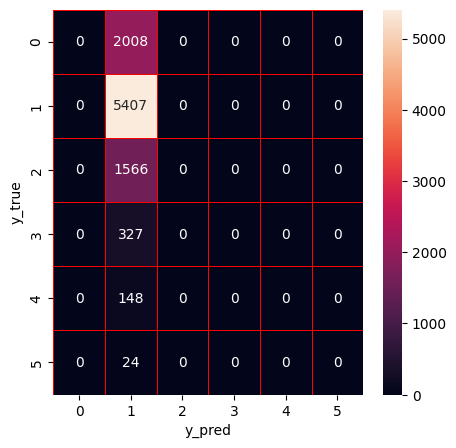



 ==================== Random Forest Classifier ==================== 


Accuracy Score: 
0.7524261603375527
Classification Report: 
              precision    recall  f1-score   support

           0       0.53      0.37      0.44      2008
           1       0.75      0.88      0.81      5407
           2       0.97      0.88      0.92      1566
           3       0.86      0.61      0.72       327
           4       0.71      0.45      0.55       148
           5       0.44      0.17      0.24        24

    accuracy                           0.75      9480
   macro avg       0.71      0.56      0.61      9480
weighted avg       0.74      0.75      0.74      9480

Confusion Matrix: 
 [[ 751 1235    9    8    3    2]
 [ 616 4734   27   18   11    1]
 [  20  158 1377    2    9    0]
 [   7  112    1  201    4    2]
 [   5   62   10    5   66    0]
 [   5   14    0    1    0    4]]


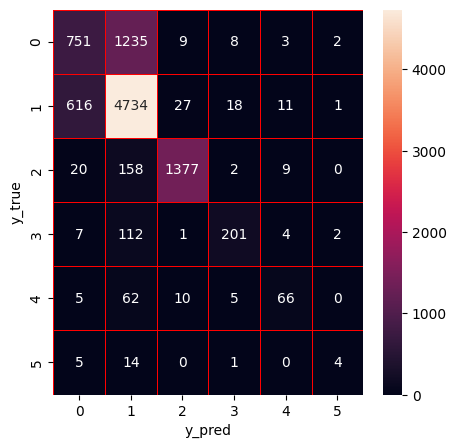

Accuracy Score: 
0.7518987341772152
Classification Report: 
              precision    recall  f1-score   support

           0       0.54      0.38      0.44      2008
           1       0.75      0.88      0.81      5407
           2       0.97      0.87      0.91      1566
           3       0.85      0.61      0.71       327
           4       0.73      0.45      0.55       148
           5       0.57      0.17      0.26        24

    accuracy                           0.75      9480
   macro avg       0.73      0.56      0.62      9480
weighted avg       0.74      0.75      0.74      9480

Confusion Matrix: 
 [[ 755 1231   11    8    3    0]
 [ 609 4741   28   19    9    1]
 [  26  169 1361    2    8    0]
 [   7  111    2  201    4    2]
 [   7   61    8    6   66    0]
 [   5   14    0    1    0    4]]


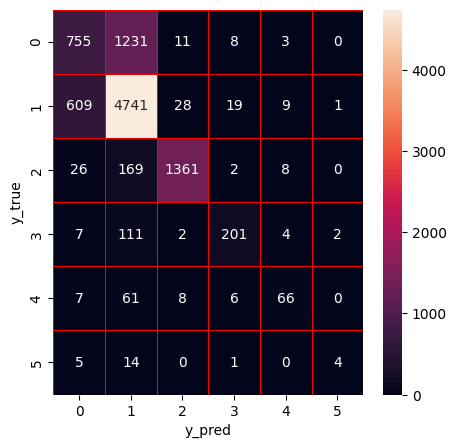



 ==================== SVM Classifier ==================== 




/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy Score: 
0.21181434599156118
Classification Report: 
              precision    recall  f1-score   support

           0       0.21      1.00      0.35      2008
           1       0.00      0.00      0.00      5407
           2       0.00      0.00      0.00      1566
           3       0.00      0.00      0.00       327
           4       0.00      0.00      0.00       148
           5       0.00      0.00      0.00        24

    accuracy                           0.21      9480
   macro avg       0.04      0.17      0.06      9480
weighted avg       0.04      0.21      0.07      9480

Confusion Matrix: 
 [[2008    0    0    0    0    0]
 [5407    0    0    0    0    0]
 [1566    0    0    0    0    0]
 [ 327    0    0    0    0    0]
 [ 148    0    0    0    0    0]
 [  24    0    0    0    0    0]]


/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/schebolu/.conda/envs/sc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


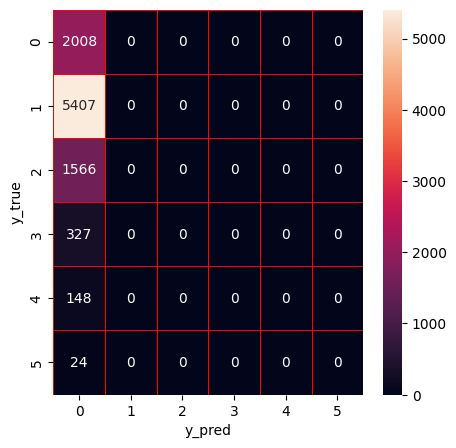

In [ ]:
for num_cats in range(5, 8):
    print("\n\n", "*" * 20, "\n\n", f"Running Expts on {ordered_attack_cats[:num_cats]}", "\n\n", "*" * 20)
    fil_df = df[df['Attack category'].isin(ordered_attack_cats[:num_cats])]
    print("len of fil_df", len(fil_df))
    print("unique cats", fil_df["Attack category"].unique())

   
    fil_df['Attack subcategory'].fillna(fil_df['Attack subcategory'].value_counts().index[0],inplace=True)
    fil_df = fil_df.dropna()
    fil_df['Attack subcategory'].fillna()
    print("len of fil_df after dropping na", len(fil_df))
    print("unique cats", fil_df["Attack category"].unique())

    new_df = fil_df.groupby('Attack category').apply(lambda x: x.sample(frac=0.8)).reset_index(drop = True).sample(frac=1.0)
    
    new_df['Attack category'] = new_df['Attack category']
    # new_df = new_df.drop(columns=["Attack Reference", "Attack subcategory"])
    new_df = new_df.drop(columns=["Attack Reference"])
    print("len of new_df", len(new_df))
    print("unique cats new_df", new_df["Attack category"].unique())

    new_df = convert_ip_num(new_df, ["Source IP", "Destination IP"])
    new_df = convert_cate_num(new_df, ["Protocol", "Attack subcategory"])
    # new_df = convert_cate_num(new_df, ["Attack category"])
    new_df["time_lapse"] = new_df["Last time"] - new_df["Start time"]
    new_df = convert_to_numeric(new_df, ["Source Port", "Destination Port"])
    new_df = convert_col_tfidf(new_df, 'Attack Name')
    new_df = new_df.drop(columns=['Attack Name', "Source IP", "Destination IP", "Last time", "Start time"])

    uniq_cat = list(new_df["Attack category"].unique())
    cat_idx_map = {cat: idx for idx, cat in enumerate(uniq_cat)}
    idx_cat_map = {idx: cat for idx, cat in enumerate(uniq_cat)}
    new_df["Attack category idx"] = new_df["Attack category"].map(cat_idx_map)

    new_df.reset_index(inplace=True, drop=True)
    new_df = new_df.drop(columns=['Attack category'])
    
    train, test = train_test_split(new_df, test_size=0.1, random_state=1234, shuffle=True)

    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)

    # Separate the Feature Columns and the Class/Label column as 'x' and 'y' respectively
    x_train = train.loc[:, new_df.columns != 'Attack category idx']
    x_test = test.loc[:, new_df.columns != 'Attack category idx']
    y_train = train['Attack category idx']
    y_test = test['Attack category idx']
    print("unique cats y_train", y_train.unique())

    
    # ******************* For Supervised Model Training *******************
    print("\n\n", "=" * 20, f"Logistic Regression Classifier", "=" * 20, "\n\n")
    apply_ml_model(
    [
        LogisticRegression(max_iter=200),
        LogisticRegression(max_iter=500),
    ])
    
    print("\n\n", "=" * 20, f"Random Forest Classifier", "=" * 20, "\n\n")
    apply_ml_model([
    RandomForestClassifier(n_estimators=200),
    RandomForestClassifier(n_estimators=500),
    ])
    

In [23]:
fil_df.isna().sum()

Start time                0
Last time                 0
Attack category           0
Attack subcategory     4097
Protocol                  0
Source IP                 0
Source Port               0
Destination IP            0
Destination Port          0
Attack Name               1
Attack Reference      49880
dtype: int64

## Unsupervised Approach - Clustering using K-Means



 ******************** 

 Running Expts on ['Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Generic', 'Backdoor', 'Analysis'] 

 ********************
len of fil_df 172411
unique cats ['Reconnaissance' 'Exploits' 'DoS' 'Generic' 'Fuzzers' 'Analysis'
 'Backdoor']


/tmp/ipykernel_6230/2997299735.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_df['Attack subcategory'].fillna(fil_df['Attack subcategory'].value_counts().index[0],inplace=True)


len of fil_df after dropping na 172410
unique cats ['Reconnaissance' 'Exploits' 'DoS' 'Generic' 'Fuzzers' 'Analysis'
 'Backdoor']
len of new_df 137929
unique cats new_df ['Exploits' 'Generic' 'Backdoor' 'Reconnaissance' 'DoS' 'Fuzzers'
 'Analysis']
unique cats y_train [3 4 5 6 0 1 2]


 ========== 7 clusters ==========
[[ 33   3   0  13   6  15   0]
 [ 35  36   0  13   2  13   1]
 [244  52  13  55 105  99   4]
 [  6   0   0   0   0   0   0]
 [ 27   3   0  11   5  14   0]
 [ 30   3   0   8   3  40   1]
 [  5   1   1   0   0   0   0]]


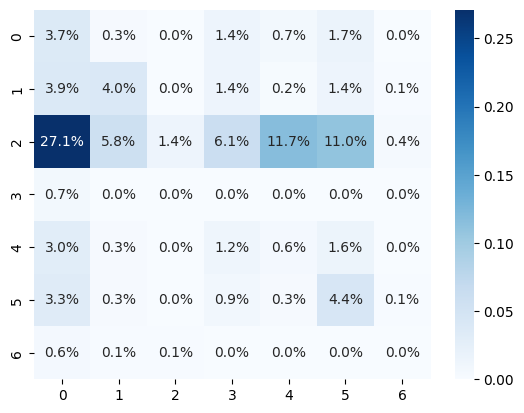

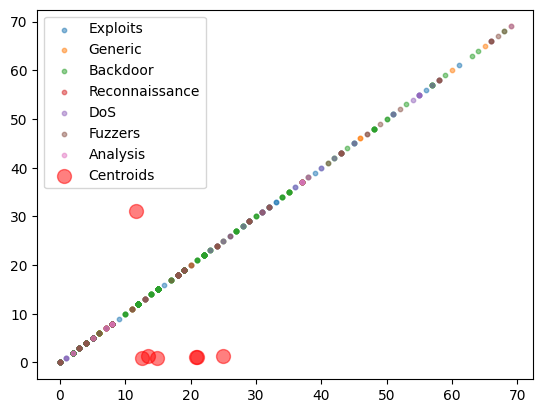

In [63]:
for num_cats in range(7, 8):
    print("\n\n", "*" * 20, "\n\n", f"Running Expts on {ordered_attack_cats[:num_cats]}", "\n\n", "*" * 20)
    fil_df = df[df['Attack category'].isin(ordered_attack_cats[:num_cats])]
    print("len of fil_df", len(fil_df))
    print("unique cats", fil_df["Attack category"].unique())

    fil_df['Attack subcategory'].fillna(fil_df['Attack subcategory'].value_counts().index[0],inplace=True)
    fil_df = fil_df.dropna()
    print("len of fil_df after dropping na", len(fil_df))
    print("unique cats", fil_df["Attack category"].unique())

    new_df = fil_df.groupby('Attack category').apply(lambda x: x.sample(frac=0.8)).reset_index(drop = True).sample(frac=1.0)
    
    new_df['Attack category'] = new_df['Attack category']
    # new_df = new_df.drop(columns=["Attack Reference", "Attack subcategory"])
    print("len of new_df", len(new_df))
    print("unique cats new_df", new_df["Attack category"].unique())

    new_df = convert_ip_num(new_df, ["Source IP", "Destination IP"])
    new_df = convert_cate_num(new_df, ["Protocol", "Attack subcategory"])
    # new_df = convert_cate_num(new_df, ["Attack category"])
    new_df["time_lapse"] = new_df["Last time"] - new_df["Start time"]
    new_df = convert_to_numeric(new_df, ["Source Port", "Destination Port"])
    new_df = convert_col_tfidf(new_df, 'Attack Name')
    new_df = new_df.drop(columns=['Attack Name', "Source IP", "Destination IP", "Last time", "Start time"])

    uniq_cat = list(new_df["Attack category"].unique())
    cat_idx_map = {cat: idx for idx, cat in enumerate(uniq_cat)}
    idx_cat_map = {idx: cat for idx, cat in enumerate(uniq_cat)}
    new_df["Attack category idx"] = new_df["Attack category"].map(cat_idx_map)

    new_df.reset_index(inplace=True, drop=True)
    new_df = new_df.drop(columns=['Attack category'])
    new_df=new_df[:1000]
    
    train, test = train_test_split(new_df, test_size=0.1, random_state=1234, shuffle=True)

    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)

    # Separate the Feature Columns and the Class/Label column as 'x' and 'y' respectively
    x_train = train.loc[:, new_df.columns != 'Attack category idx']
    x_test = test.loc[:, new_df.columns != 'Attack category idx']
    y_train = train['Attack category idx']
    y_test = test['Attack category idx']
    print("unique cats y_train", y_train.unique())

    # ******************* For KMeans Clustering *************************
    for clusters in range(7, num_cats + 1):
        print("\n\n", "=" * 10, f"{clusters} clusters", "=" * 10)
        run_kmeans(clusters, x_train, y_train, cat_idx_map, idx_cat_map)
